In [1]:
### import libraries we will be using

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks', 
    context='talk', 
    font_scale=0.8, 
    rc={'figure.figsize': (4,4)}
)



from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder,TargetEncoder

from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report, ConfusionMatrixDisplay

import lightgbm as lgb

from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTENC 
from imblearn.pipeline import Pipeline
from imblearn.ensemble import EasyEnsembleClassifier

## set a random seed for reproducibility
np.random.seed(234)

import warnings
warnings.simplefilter("ignore")

In [2]:
### using mlflow to track experiments

# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_experiment("Alvin_smart_money")

In [3]:
## import our csv into a dataframe using pandas

train = pd.read_csv("Train.csv", infer_datetime_format=True)
test = pd.read_csv("Test.csv",infer_datetime_format=True)
extra = pd.read_csv("extra_data.csv", infer_datetime_format=True)
sub = pd.read_csv("SampleSubmission.csv")

In [4]:
train.head(2)

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
0,2022-05-04 10:25:50.588042+00,UONSDA CHURCH MOGERE MWAYO TITHE,Rent / Mortgage,1700,2022-05-04 13:56:00+00,False,NaN,Male,3,10000,ID_ZX4DCF4K,ID_04mk78fa
1,2021-10-25 16:18:38.586837+00,PARK N GO,Transport & Fuel,100,2021-10-24 14:12:00+00,False,25.0,Female,4,90000,ID_U9WZMGJZ,ID_04xkfb07


In [5]:
extra.head(2)

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
0,NaN,MARK NYABAYO,NaN,20,2021-03-22 12:37:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_v13grrw3
1,NaN,ACCESS AFYA,NaN,1,2021-07-05 11:07:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_rgne8ij5


In [6]:
train["MERCHANT_CATEGORIZED_AS"].value_counts()

Bills & Fees        78
Groceries           50
Data & WiFi         43
Miscellaneous       43
Family & Friends    41
Going out           41
Transport & Fuel    29
Shopping            21
Emergency fund      12
Health               6
Loan Repayment       5
Rent / Mortgage      2
Education            2
Name: MERCHANT_CATEGORIZED_AS, dtype: int64

In [7]:
train[train["MERCHANT_CATEGORIZED_AS"] == "Education"]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
108,2022-04-12 15:57:05.758311+00,LIPA KARO KCB ACCOUNT,Education,71000,2022-02-04 08:38:00+00,False,NaN,Male,5,252000,ID_3JA0MAFB,ID_a91pnpbp
191,2021-10-05 12:29:13.14963+00,CITAM BUSINESS FORUM CBF ON,Education,1500,2021-10-19 09:02:00+00,False,25.0,Female,4,90000,ID_U9WZMGJZ,ID_iz8r11c8


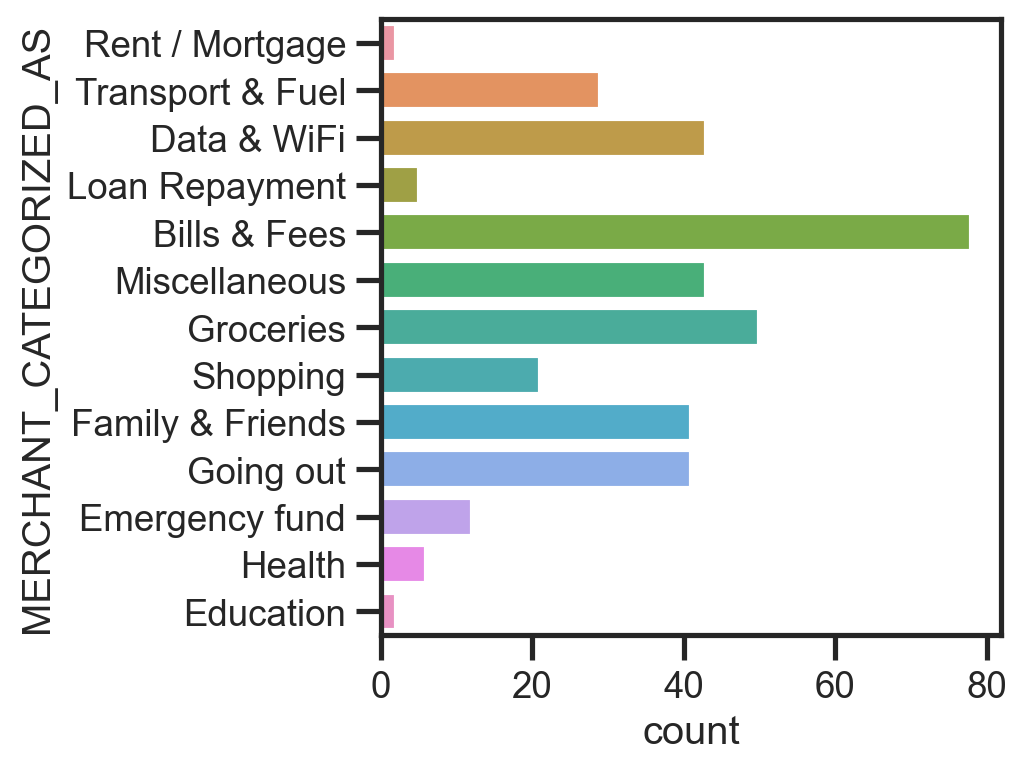

In [8]:
## Distribution of our target variable
sns.countplot(y="MERCHANT_CATEGORIZED_AS", data=train);

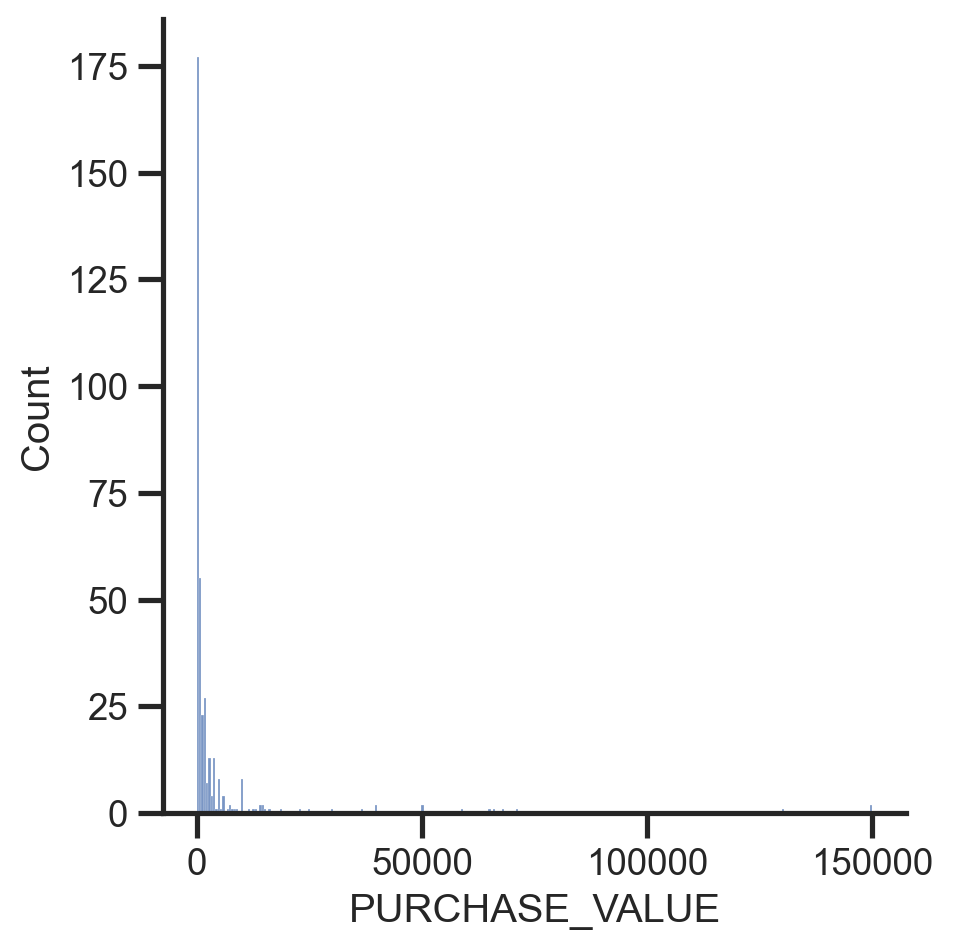

In [9]:
## Distribution of purchase value
sns.displot(x="PURCHASE_VALUE", data=train);

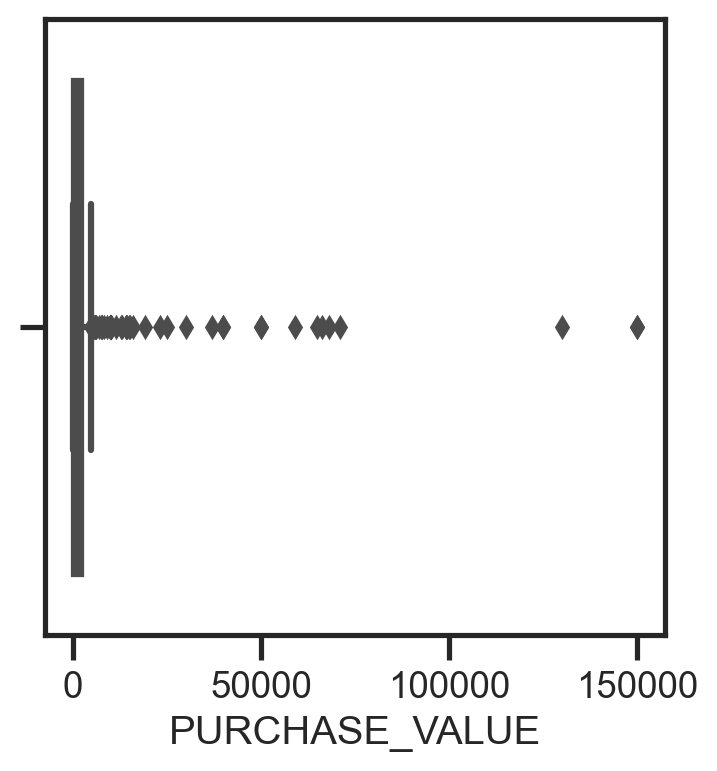

In [10]:
## boxplot of purchase value
sns.boxplot(x="PURCHASE_VALUE", data=train);

In [11]:
## transform non-numerical labels
le = LabelEncoder()
train["MERCHANT_CATEGORIZED_AS"] = le.fit_transform(train["MERCHANT_CATEGORIZED_AS"])

In [12]:
## check for missing values
train.isnull().sum()

MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
MERCHANT_CATEGORIZED_AS                    0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 312
USER_GENDER                                6
USER_HOUSEHOLD                             0
USER_INCOME                                0
USER_ID                                    0
Transaction_ID                             0
dtype: int64

In [13]:
def feat_eng(df1, df2):
    ## combine the train and test dataframe
    df = df1.append(df2, ignore_index=True)
    
    ### convert to pandas datetime
    df["PURCHASED_AT"] = pd.to_datetime(df["PURCHASED_AT"])
    
    ### do a log transformation on purchase value to deal with the outliers
    df["PURCHASE_VALUE"] = np.log(df["PURCHASE_VALUE"])
    
    ## extract features from the date feature
    df["day"] = df["PURCHASED_AT"].dt.day
    df["week"] = df["PURCHASED_AT"].dt.week
    df["hour"] = df["PURCHASED_AT"].dt.hour
    df["minute"] = df["PURCHASED_AT"].dt.minute
    
    ## create new features using groupby
    df["MERCHANT_NAME_count"] = df.groupby("MERCHANT_NAME")["MERCHANT_CATEGORIZED_AS"].transform("count")
    df["USER_INCOME_enc"] = df.groupby("USER_INCOME")["MERCHANT_CATEGORIZED_AS"].transform("mean")
    df["feat"] = df["MERCHANT_NAME"].str.contains("SAFARICOM")
    
    df.drop(columns=["Transaction_ID","USER_ID","MERCHANT_CATEGORIZED_AT","MERCHANT_NAME","PURCHASED_AT"]
            , axis=1, inplace=True)
    
    df1 = df[:373]
    df2 = df.drop(columns=["MERCHANT_CATEGORIZED_AS"])[373:]
    
    return df1, df2

In [14]:
train, test = feat_eng(train, test)

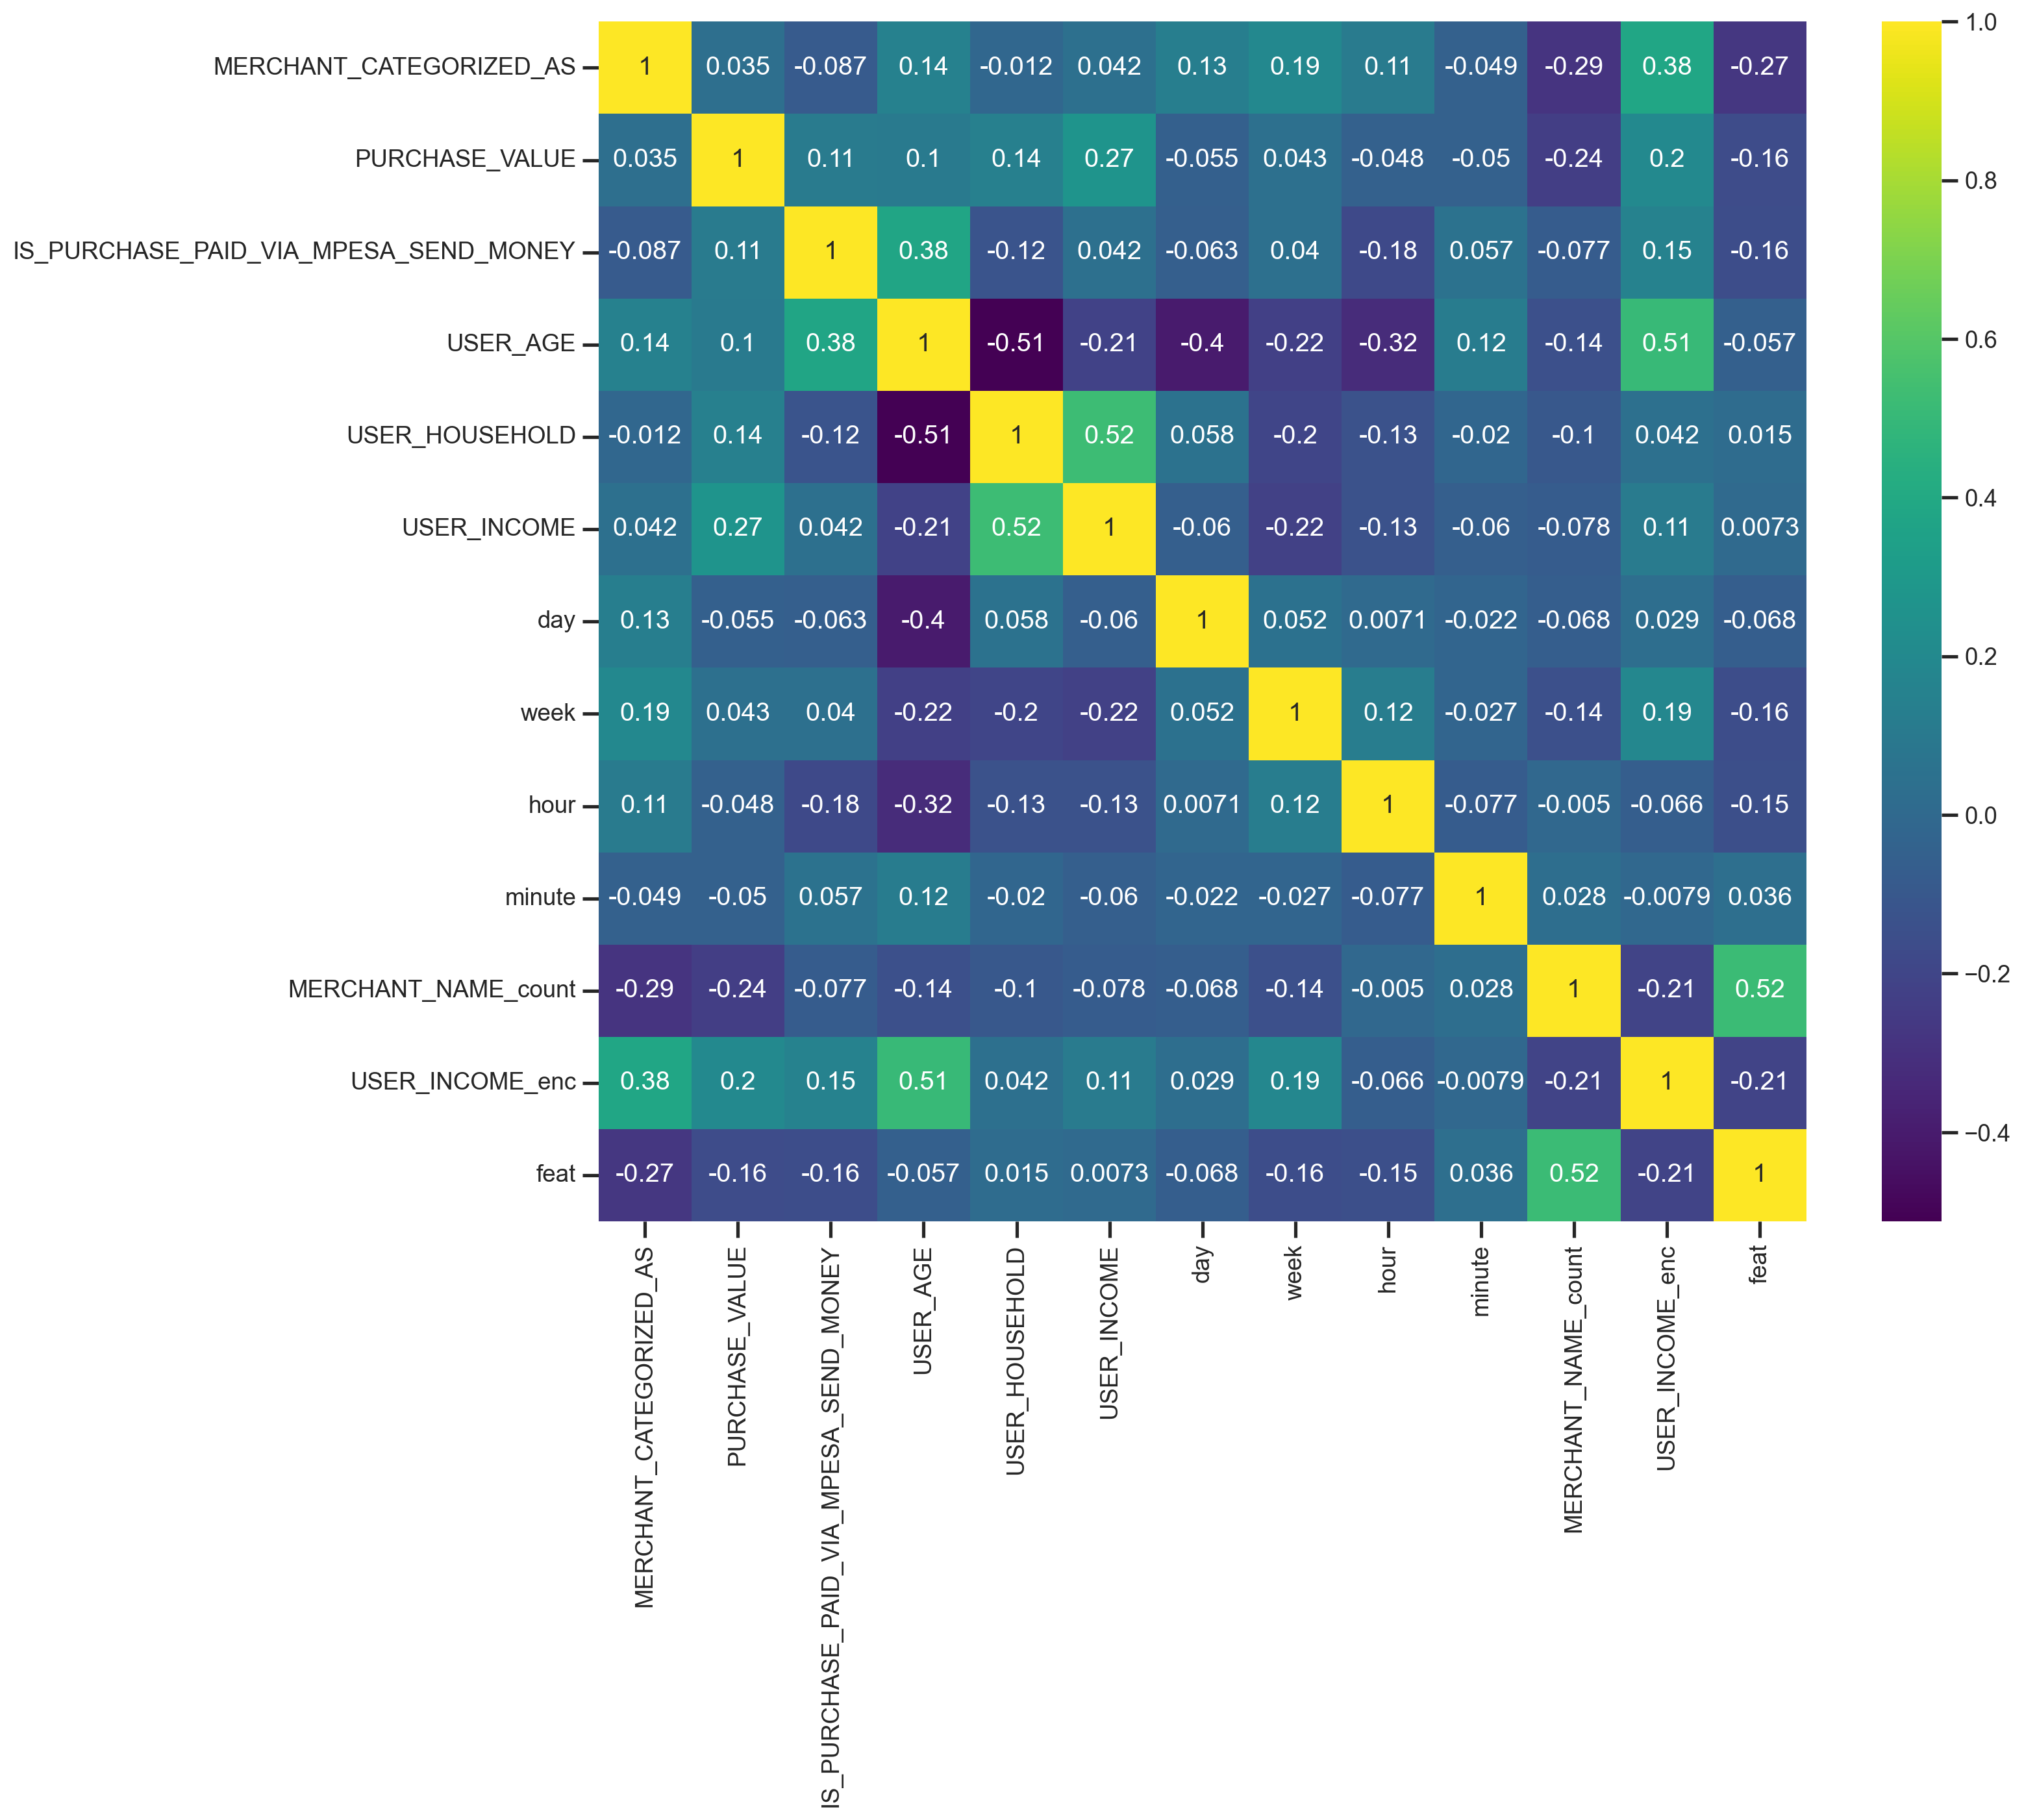

In [15]:
## plot a correlation heatmap

fig = plt.figure(figsize=(15,12))
corr = train.corr()
sns.heatmap(corr, cmap="viridis", annot=True);

In [16]:
test.shape, train.shape

((558, 13), (373, 14))

In [17]:
# Drop our target vairable

target = "MERCHANT_CATEGORIZED_AS"
X = train.drop(columns=target)
y = train[target]

In [18]:
# filter out data set into numeric and categorical features. 

numeric = X.select_dtypes(exclude="object").columns.tolist()
categorical = X.select_dtypes(include="object").columns.tolist()

In [19]:
## create a pipeline for the numeric features

numeric_transformer = Pipeline(
    steps=[
        ("imputer",SimpleImputer(strategy="median")),
        ("Poly",PolynomialFeatures()),
        ("kbest", SelectKBest(f_classif, k=25)),
        ("scaler", StandardScaler())
    ]

).set_output(transform="pandas")

In [20]:
## create a pipeline for the categorical features

categorical_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy='most_frequent')),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary'))
    ]
).set_output(transform="pandas")

In [21]:
## use columntransformer to combine the two pipelines

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric),
        ("cat", categorical_transformer, categorical)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [22]:
## split the model into a train and test split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [23]:
## pipeline for the preprocessor pipeline and xgboost classifier
model_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("xgb", XGBClassifier())
    ]
)

preprocessor.fit(x_train, y_train)

model_pipe.fit(x_train, y_train, xgb__eval_set=[(preprocessor.transform(x_val), y_val)],
              xgb__early_stopping_rounds=10)

# model_pipe.fit(x_train, y_train)

[0]	validation_0-mlogloss:2.09446
[1]	validation_0-mlogloss:1.90969
[2]	validation_0-mlogloss:1.76795
[3]	validation_0-mlogloss:1.66798
[4]	validation_0-mlogloss:1.60582
[5]	validation_0-mlogloss:1.54256
[6]	validation_0-mlogloss:1.49275
[7]	validation_0-mlogloss:1.46765
[8]	validation_0-mlogloss:1.45203
[9]	validation_0-mlogloss:1.44066
[10]	validation_0-mlogloss:1.42616
[11]	validation_0-mlogloss:1.40899
[12]	validation_0-mlogloss:1.40109
[13]	validation_0-mlogloss:1.39544
[14]	validation_0-mlogloss:1.38894
[15]	validation_0-mlogloss:1.39028
[16]	validation_0-mlogloss:1.39296
[17]	validation_0-mlogloss:1.39930
[18]	validation_0-mlogloss:1.41453
[19]	validation_0-mlogloss:1.41770
[20]	validation_0-mlogloss:1.42081
[21]	validation_0-mlogloss:1.41966
[22]	validation_0-mlogloss:1.42977
[23]	validation_0-mlogloss:1.42967


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Poly',
                                                                   PolynomialFeatures()),
                                                                  ('kbest',
                                                                   SelectKBest(k=25)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PURCHASE_VALUE',
                                                   'IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY',
                                                   'USER_AGE', 'USER_HOUSEHOLD',
                                                   'USER_INCOME', 'day',...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [24]:
## predict on the test set using the model's best iteration

best_iteration = model_pipe.named_steps.xgb.best_iteration
preds = model_pipe.predict_proba(test, iteration_range=(0, best_iteration + 1))

In [25]:
## feature importance
importance = model_pipe.named_steps.xgb.feature_importances_
index = model_pipe.named_steps.preprocessor.get_feature_names_out

In [26]:
features = pd.DataFrame({"importance":importance}, index=index())

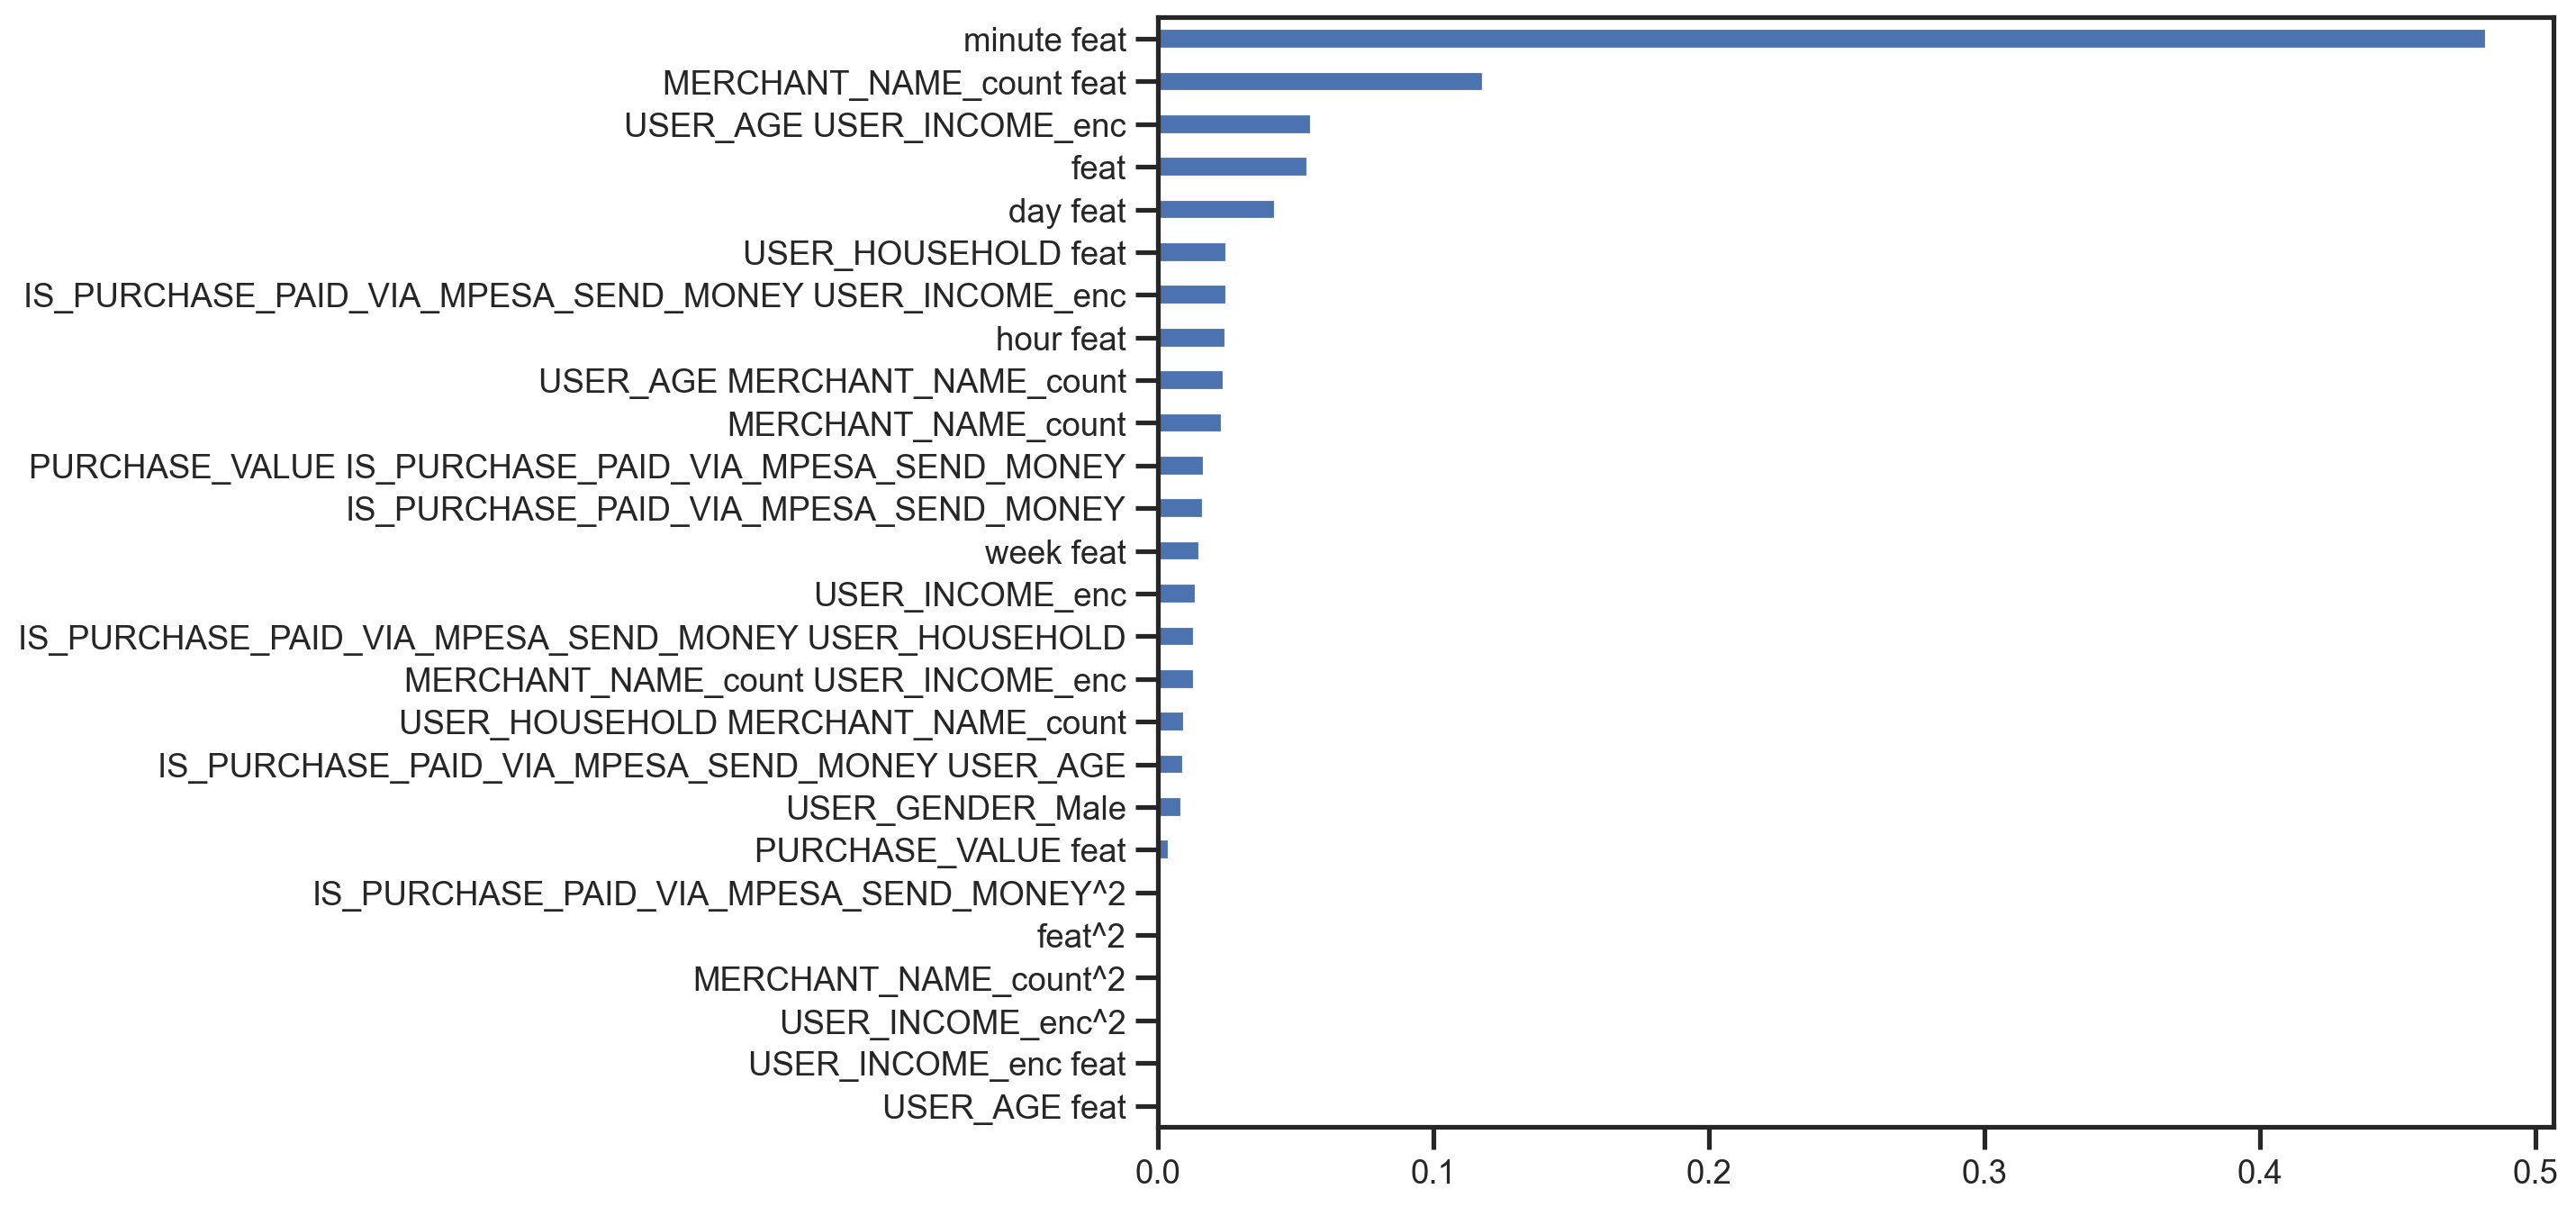

In [27]:
## plot the feature importance
plt.figure(figsize=(10,8))
features["importance"].sort_values().plot(kind="barh");

##### predict on the submission file and save to csv for submission to the competition site

In [28]:
cols = ['Bills & Fees', 'Data & WiFi', 'Education','Emergency fund', 'Family & Friends', 'Going out', 
        'Groceries','Health', 'Loan Repayment', 'Miscellaneous', 'Rent / Mortgage','Shopping',
        'Transport & Fuel']

In [29]:
sub[cols] = preds

In [30]:
sub.to_csv("submission.csv", index=False)
sub.head()

,Transaction_ID,Bills & Fees,Data & WiFi,Education,Emergency fund,Family & Friends,Going out,Groceries,Health,Loan Repayment,Miscellaneous,Rent / Mortgage,Shopping,Transport & Fuel
0,ID_00x9h2yx,0.127402,0.082133,0.011065,0.036364,0.477226,0.025808,0.029823,0.012927,0.019956,0.025730,0.077018,0.060857,0.013690
1,ID_01db594f,0.098434,0.022546,0.009740,0.010274,0.016793,0.655264,0.016745,0.009132,0.008430,0.049018,0.023230,0.064845,0.015548
2,ID_07pm99no,0.035688,0.012878,0.011118,0.014616,0.013249,0.077324,0.396590,0.012681,0.010389,0.257297,0.010052,0.017469,0.130649
3,ID_09jryhkd,0.143323,0.105118,0.011275,0.011894,0.027158,0.345526,0.015718,0.012061,0.033718,0.056746,0.030178,0.189284,0.018000
4,ID_0ccv924c,0.143323,0.105118,0.011275,0.011894,0.027158,0.345526,0.015718,0.012061,0.033718,0.056746,0.030178,0.189284,0.018000
